#IMPORT NECESSARY LIBRARIES

In [1]:
import os
import random
random.seed = 42
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import time

In [2]:
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications import VGG19, ResNet50V2, InceptionV3, Xception
from keras.models import Model, Sequential
from keras.layers import concatenate, Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
# from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import to_categorical

In [3]:
import imgaug.augmenters as iaa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from skimage import io

##Define runtime

In [4]:
!pip install ipython-autotime
%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.2 MB/s eta 0:00:00
time: 442 µs (started: 2024-07-29 06:44:06 +00:00)


#DATA PREPARATION

##Get Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/MASTER 1/Internship/ICT Lab/WORKSPACE/data/ISIC_2019/'

training_input_zip = data_dir + '/ISIC_2019_Training_Input.zip'
test_input_zip = data_dir + '/ISIC_2019_Test_Input.zip'

training_Metadata = data_dir + '/ISIC_2019_Training_Metadata.csv'
training_GroundTruth =  data_dir + '/ISIC_2019_Training_GroundTruth.csv'
test_Metadata = data_dir + '/ISIC_2019_Test_Metadata.csv'

training_input_dir = data_dir + '/ISIC_2019_Training_Input'
test_input_dir = data_dir + '/ISIC_2019_Test_Input'

Mounted at /content/drive
time: 17.7 s (started: 2024-07-29 07:04:06 +00:00)


In [6]:
# !unzip "$training_input_zip"
# !unzip "$test_input_zip"

time: 1.02 ms (started: 2024-07-29 07:04:24 +00:00)


##Import data

###Meta-data

In [7]:
train_metadata=pd.read_csv(training_Metadata)
train_metadata

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male
...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female


time: 1.82 s (started: 2024-07-29 07:04:24 +00:00)


In [8]:
train_groundtruth=pd.read_csv(training_GroundTruth)
# Drop the 'UNK' column
train_groundtruth = train_groundtruth.drop(columns=['UNK'])
train_groundtruth

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 517 ms (started: 2024-07-29 07:04:26 +00:00)


In [9]:
test_metadata=pd.read_csv(test_Metadata)
test_metadata

,image,age_approx,anatom_site_general,sex
0,ISIC_0034321,60.0,NaN,female
1,ISIC_0034322,70.0,anterior torso,male
2,ISIC_0034323,70.0,lower extremity,male
3,ISIC_0034324,70.0,lower extremity,male
4,ISIC_0034325,30.0,upper extremity,female
...,...,...,...,...
8233,ISIC_0073236,75.0,anterior torso,male
8234,ISIC_0073243,65.0,lower extremity,male
8235,ISIC_0073250,30.0,anterior torso,female
8236,ISIC_0073252,85.0,head/neck,female


time: 342 ms (started: 2024-07-29 07:04:26 +00:00)


###Meta-data information

In [10]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB
time: 33.9 ms (started: 2024-07-29 07:04:27 +00:00)


In [11]:
train_groundtruth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   25331 non-null  object 
 1   MEL     25331 non-null  float64
 2   NV      25331 non-null  float64
 3   BCC     25331 non-null  float64
 4   AK      25331 non-null  float64
 5   BKL     25331 non-null  float64
 6   DF      25331 non-null  float64
 7   VASC    25331 non-null  float64
 8   SCC     25331 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.7+ MB
time: 12.6 ms (started: 2024-07-29 07:04:27 +00:00)


In [12]:
test_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8238 entries, 0 to 8237
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                8238 non-null   object 
 1   age_approx           7912 non-null   float64
 2   anatom_site_general  7583 non-null   object 
 3   sex                  7899 non-null   object 
dtypes: float64(1), object(3)
memory usage: 257.6+ KB
time: 8.04 ms (started: 2024-07-29 07:04:27 +00:00)


In [13]:
def print_unique_counts(df, df_name):
    print(f"\n{'-'*40}")
    print(f"{df_name.upper()}")
    print(f"{'-'*40}")

    unique_counts = df.nunique()
    print("\nUnique entries in each column:")
    for col in unique_counts.index:
        print(f"- {col}: {unique_counts[col]}")

# Now use the function for each dataframe
print_unique_counts(train_metadata, 'Train Metadata')
print_unique_counts(train_groundtruth, 'Train Groundtruth')
print_unique_counts(test_metadata, 'Test Metadata')



----------------------------------------
TRAIN METADATA
----------------------------------------

Unique entries in each column:
- image: 25331
- age_approx: 18
- anatom_site_general: 8
- lesion_id: 11847
- sex: 2

----------------------------------------
TRAIN GROUNDTRUTH
----------------------------------------

Unique entries in each column:
- image: 25331
- MEL: 2
- NV: 2
- BCC: 2
- AK: 2
- BKL: 2
- DF: 2
- VASC: 2
- SCC: 2

----------------------------------------
TEST METADATA
----------------------------------------

Unique entries in each column:
- image: 8238
- age_approx: 18
- anatom_site_general: 7
- sex: 2
time: 42.1 ms (started: 2024-07-29 07:04:27 +00:00)


In [14]:
train_metadata['anatom_site_general'].unique()

array(['anterior torso', 'upper extremity', 'posterior torso',
       'lower extremity', nan, 'lateral torso', 'head/neck',
       'palms/soles', 'oral/genital'], dtype=object)

time: 6.35 ms (started: 2024-07-29 07:04:27 +00:00)


##Data Analysis

###Meta-data describe

In [15]:
def describe_and_check_nulls(df, df_name):
    print(f"\n{'-'*40}")
    print(f"{df_name.upper()}")
    print(f"{'-'*40}")

    print("\nDescription:")
    print(df.describe(include='all'))

    print("\nNull Values:")
    null_values = df.isnull().sum()
    print(null_values)

    print("\nPercentage of Null Values:")
    print(null_values / len(df) * 100)

# Now use the function for each dataframe
describe_and_check_nulls(train_metadata, 'Train Metadata')
describe_and_check_nulls(train_groundtruth, 'Train Groundtruth')
describe_and_check_nulls(test_metadata, 'Test Metadata')



----------------------------------------
TRAIN METADATA
----------------------------------------

Description:
               image    age_approx anatom_site_general    lesion_id    sex
count          25331  24894.000000               22700        23247  24947
unique         25331           NaN                   8        11847      2
top     ISIC_0000000           NaN      anterior torso  BCN_0001728   male
freq               1           NaN                6915           31  13286
mean             NaN     54.028481                 NaN          NaN    NaN
std              NaN     18.130971                 NaN          NaN    NaN
min              NaN      0.000000                 NaN          NaN    NaN
25%              NaN     40.000000                 NaN          NaN    NaN
50%              NaN     55.000000                 NaN          NaN    NaN
75%              NaN     70.000000                 NaN          NaN    NaN
max              NaN     85.000000                 NaN         

In [16]:
# train_metadata.describe(include='all')
# train_groundtruth.describe(include='all')
# test_metadata.describe(include='all')

# print("\ntrain_metadata")
# print(train_metadata.isnull().sum())
# print("\ntrain_groundtruth")
# print(train_groundtruth.isnull().sum())
# print("\ntest_metadata")
# print(test_metadata.isnull().sum())

time: 374 µs (started: 2024-07-29 07:04:27 +00:00)


###Plot data

In [17]:
# List of dataframes
dfs = [train_metadata, train_groundtruth, test_metadata]
df_names = ['train_metadata', 'train_groundtruth', 'test_metadata']

time: 5.38 ms (started: 2024-07-29 07:04:27 +00:00)


Plot missing values

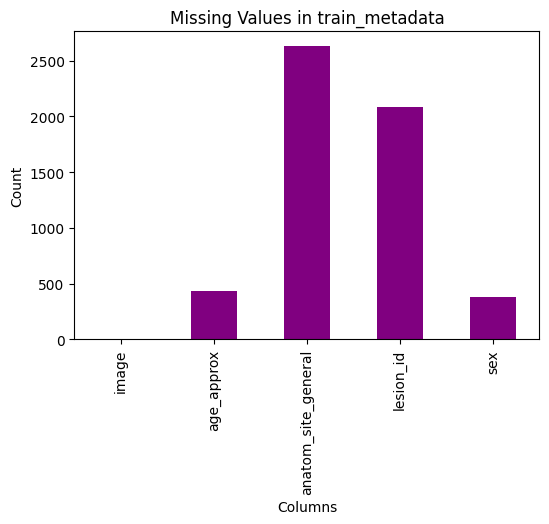

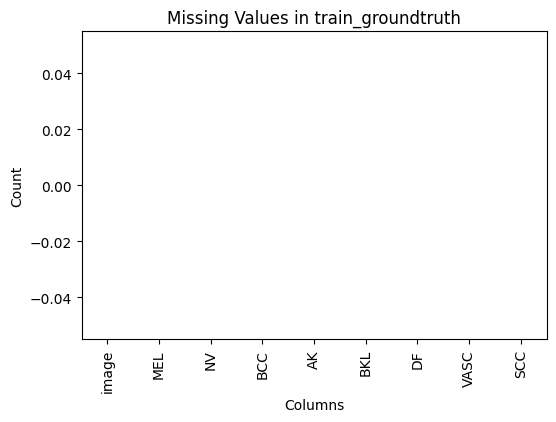

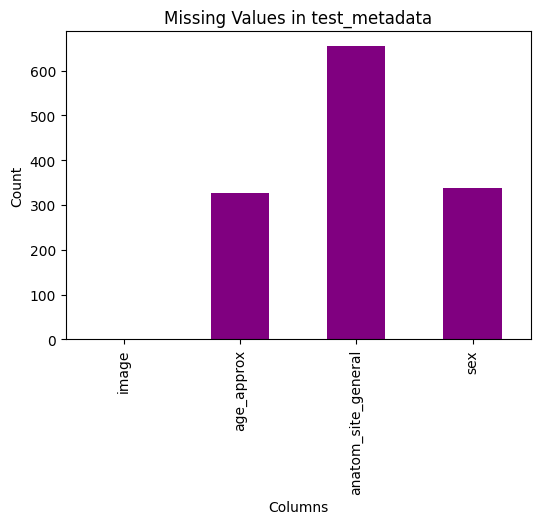

time: 1.15 s (started: 2024-07-29 07:04:27 +00:00)


In [18]:
# Loop through dataframes
for i, df in enumerate(dfs):
    # Calculate missing values
    missing_values = df.isnull().sum()

    # Plot missing values
    plt.figure(figsize=(6, 4))
    missing_values.plot(kind='bar', color='purple')
    plt.title('Missing Values in ' + df_names[i])
    plt.ylabel('Count')
    plt.xlabel('Columns')
    plt.show()


In [19]:
# Describe each dataframe
def describe_columns(df, df_name):
    print(f"\n{'-'*40}")
    print(f"{df_name.upper()}")
    print(f"{'-'*40}")

    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    print("\nNumerical Columns:")
    for col in numerical_cols:
        print(f"- {col}")

    print("\nCategorical Columns:")
    for col in categorical_cols:
        print(f"- {col}")

# Describe each dataframe
describe_columns(train_metadata, 'Train Metadata')
describe_columns(train_groundtruth, 'Train Groundtruth')
describe_columns(test_metadata, 'Test Metadata')



----------------------------------------
TRAIN METADATA
----------------------------------------

Numerical Columns:
- age_approx

Categorical Columns:
- image
- anatom_site_general
- lesion_id
- sex

----------------------------------------
TRAIN GROUNDTRUTH
----------------------------------------

Numerical Columns:
- MEL
- NV
- BCC
- AK
- BKL
- DF
- VASC
- SCC

Categorical Columns:
- image

----------------------------------------
TEST METADATA
----------------------------------------

Numerical Columns:
- age_approx

Categorical Columns:
- image
- anatom_site_general
- sex
time: 19.2 ms (started: 2024-07-29 07:04:28 +00:00)


In [20]:
# Define categorical and numerical columns
categorical_columns = ['lesion_id', 'image', 'anatom_site_general', 'sex']
numerical_columns = ['age_approx']


time: 648 µs (started: 2024-07-29 07:04:28 +00:00)


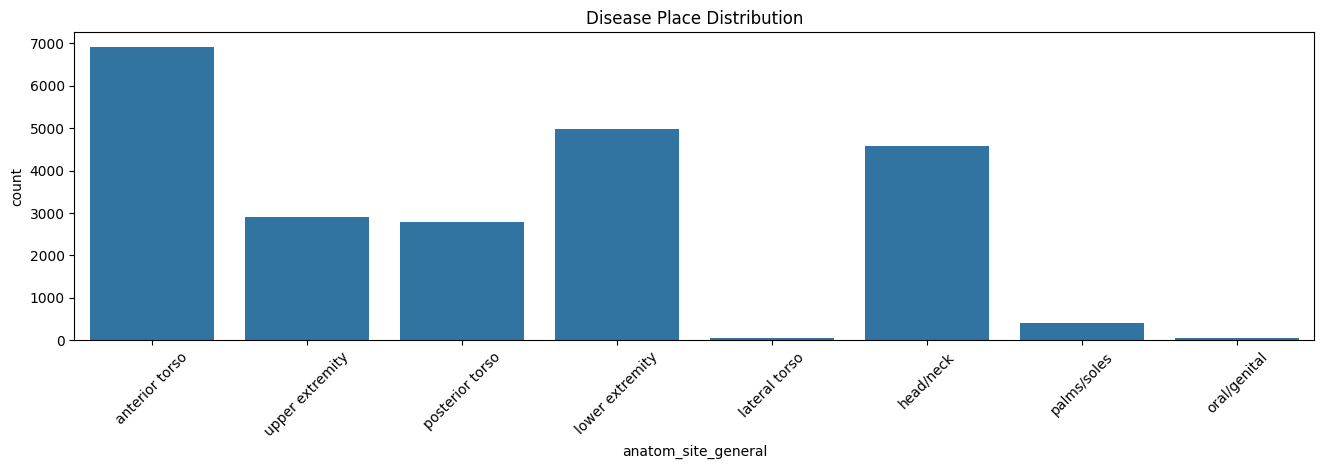

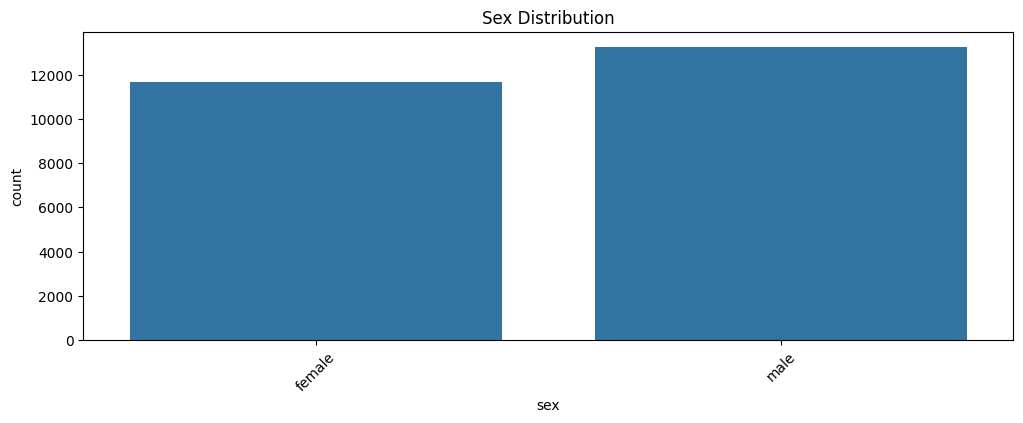

time: 923 ms (started: 2024-07-29 07:04:28 +00:00)


In [21]:
# Distribution of value count for Location of disease
for column in categorical_columns:
    train_metadata['anatom_site_general'].value_counts()

train_metadata['anatom_site_general'].value_counts()

plt.figure(figsize=(16, 4))
sns.countplot(data=train_metadata, x='anatom_site_general')
plt.title('Disease Place Distribution')
plt.xticks(rotation=45)
plt.show()

# Distribution of value count for Sex in the dataset
for column in categorical_columns:
    train_metadata['sex'].value_counts()

train_metadata['sex'].value_counts()

plt.figure(figsize=(12, 4))
sns.countplot(data=train_metadata, x='sex')
plt.title('Sex Distribution')
plt.xticks(rotation=45)
plt.show()

# # Distribution of value count for Type of disease
# for column in categorical_columns:
#     train_metadata['lesion_id'].value_counts()

# train_metadata['lesion_id'].value_counts()

# plt.figure(figsize=(12, 4))
# sns.countplot(data=train_metadata, x='lesion_id')
# plt.title('Lesion ID Distribution')
# plt.xticks(rotation=45)
# plt.show()

# # Distribution of value count for Type of disease
# for column in categorical_columns:
#     train_metadata['image'].value_counts()

# train_metadata['image'].value_counts()

# plt.figure(figsize=(12, 4))
# sns.countplot(data=train_metadata, x='image')
# plt.title('Image Name Distribution')
# plt.xticks(rotation=45)
# plt.show()

<ipython-input-22-57af30f33fcc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=disease_type_counts_df, x='Disease Type', y='Count', palette='viridis')


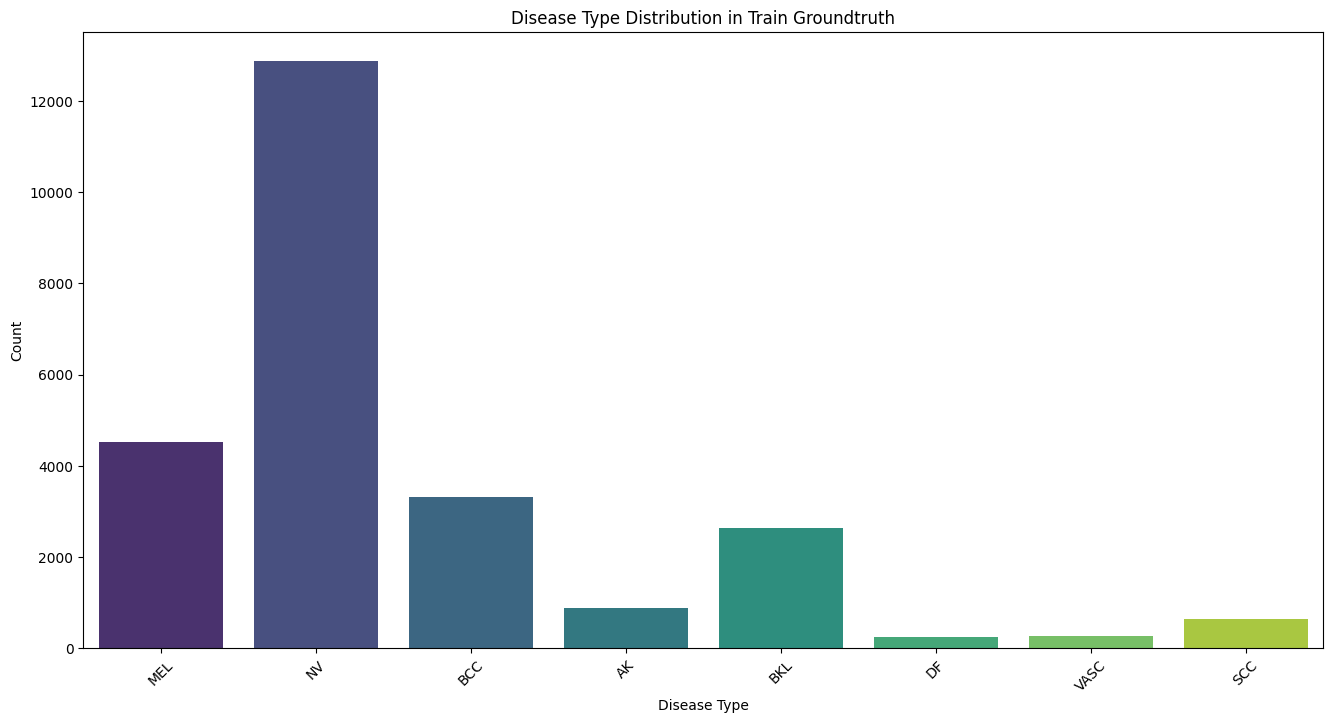

time: 700 ms (started: 2024-07-29 07:04:29 +00:00)


In [22]:
# Define columns to plot (excluding 'image' and 'UNK')
disease_type = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

# Sum up the counts of each class
disease_type_counts = train_groundtruth[disease_type].sum()

# Convert to DataFrame for easier plotting
disease_type_counts_df = pd.DataFrame(disease_type_counts).reset_index()
disease_type_counts_df.columns = ['Disease Type', 'Count']

# Plot
plt.figure(figsize=(16, 8))
sns.barplot(data=disease_type_counts_df, x='Disease Type', y='Count', palette='viridis')
plt.title('Disease Type Distribution in Train Groundtruth')
plt.xlabel('Disease Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


###Data Analysis for Relationship among variables

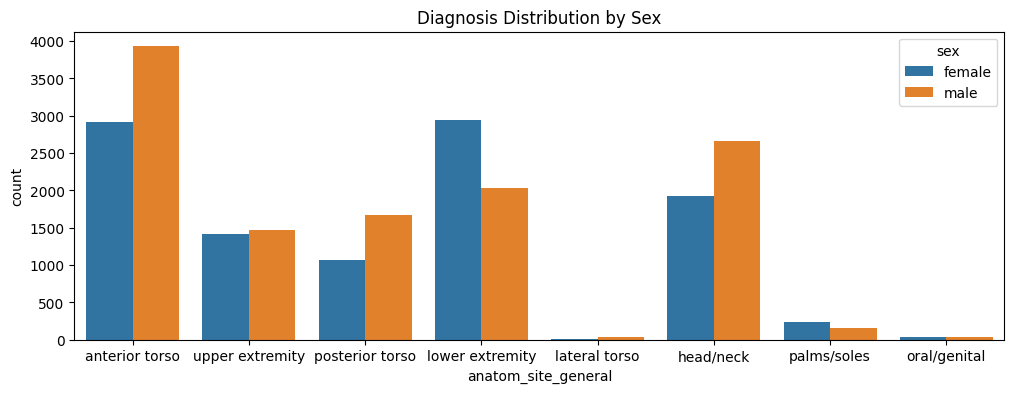

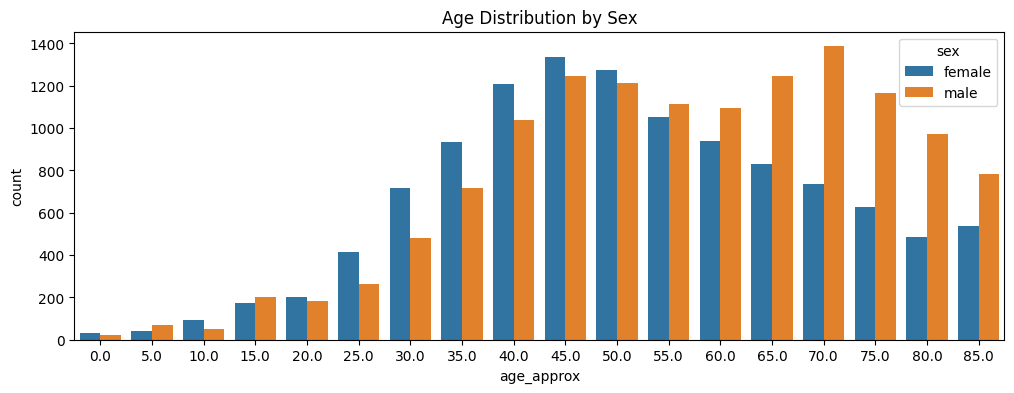

time: 1.85 s (started: 2024-07-29 07:04:30 +00:00)


In [23]:
# Visualizing relationships between anatom_site_general and sex
plt.figure(figsize=(12, 4))
sns.countplot(data=train_metadata, x='anatom_site_general', hue='sex')
plt.title('Diagnosis Distribution by Sex')
plt.show()

# Visualizing relationships between age_approx and sex
plt.figure(figsize=(12, 4))
sns.countplot(data=train_metadata, x='age_approx', hue='sex')
plt.title('Age Distribution by Sex')
plt.show()

In [24]:
# Merge the metadata and groundtruth dataframes on the 'image' column
combined_df = pd.merge(train_metadata, train_groundtruth, on='image')

# Melt the dataframe to have disease types as a single column
melted_df = pd.melt(combined_df, id_vars=['image', 'sex', 'age_approx', 'anatom_site_general'], value_vars=disease_type)

# Filter out rows where value is 0 (i.e., the disease type is not present)
filtered_df = melted_df[melted_df['value'] == 1]

time: 199 ms (started: 2024-07-29 07:04:32 +00:00)


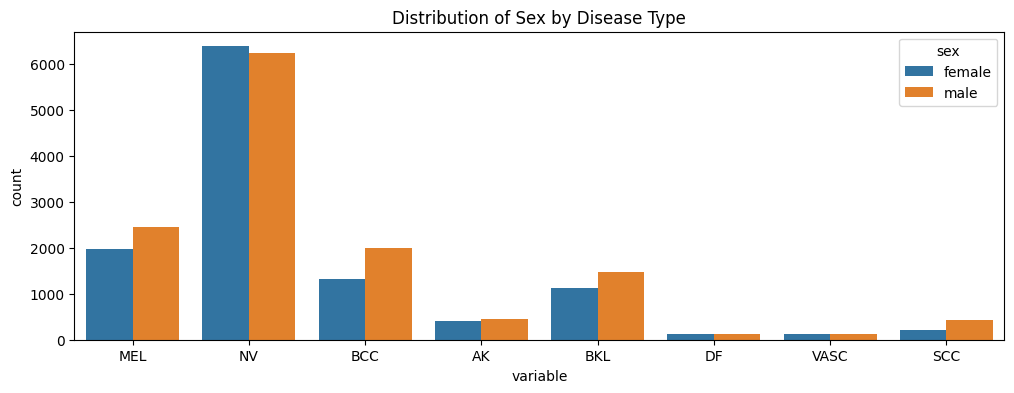

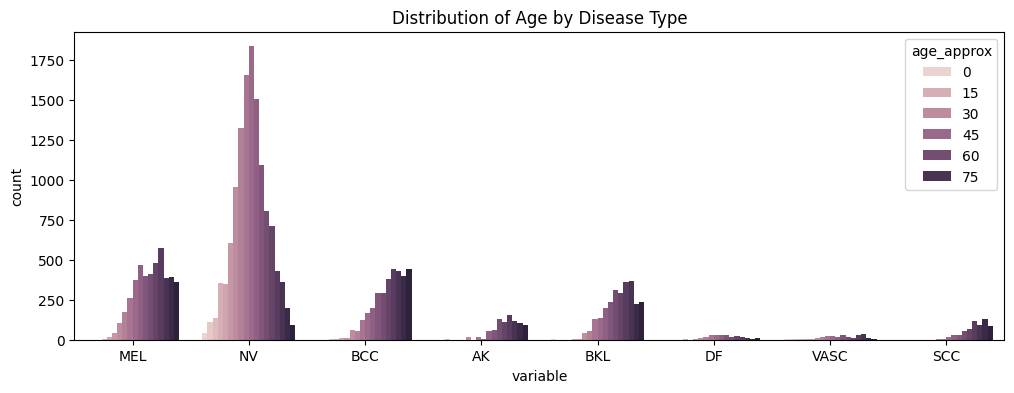

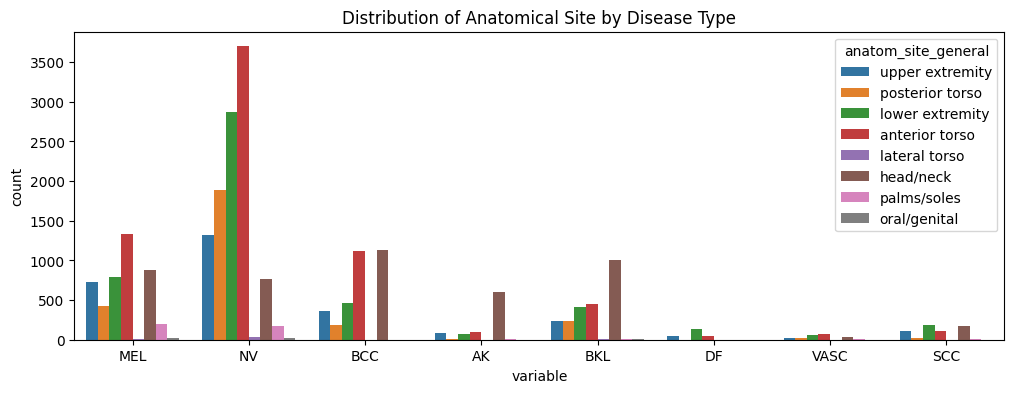

time: 3.91 s (started: 2024-07-29 07:04:32 +00:00)


In [25]:
# Plot the distribution of 'sex' by disease type
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='variable', hue='sex')
plt.title('Distribution of Sex by Disease Type')
plt.show()

# Plot the distribution of 'age_approx' by disease type
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='variable', hue='age_approx')
plt.title('Distribution of Age by Disease Type')
plt.show()

# Plot the distribution of 'anatom_site_general' by disease type
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='variable', hue='anatom_site_general')
plt.title('Distribution of Anatomical Site by Disease Type')
plt.show()

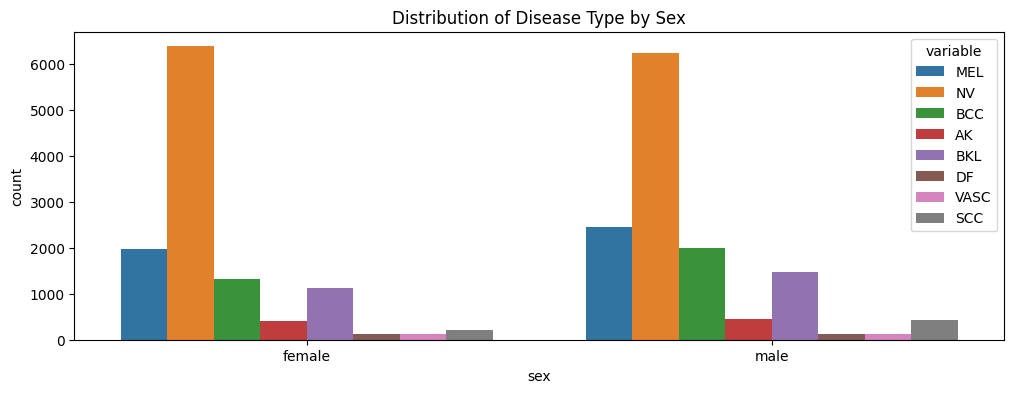

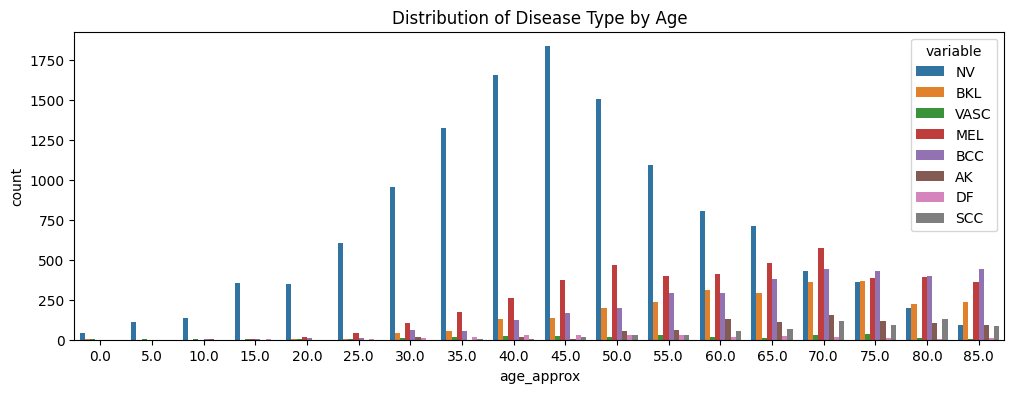

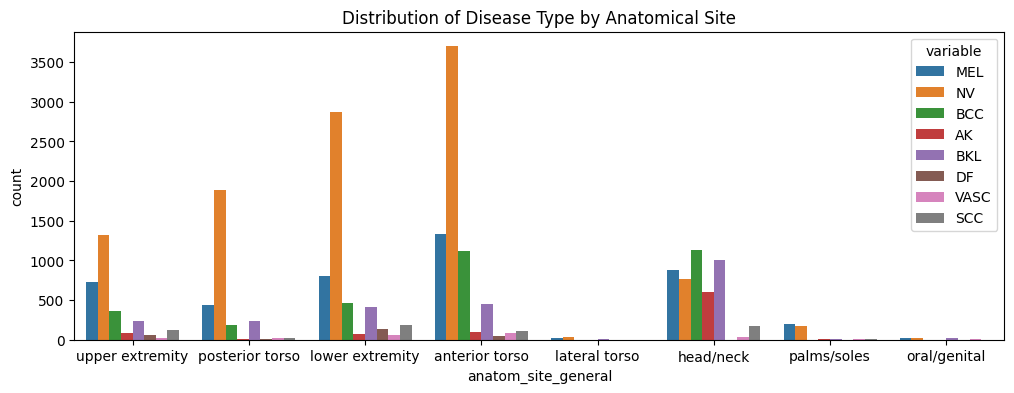

time: 2.45 s (started: 2024-07-29 07:04:36 +00:00)


In [26]:
# Plot the distribution of disease type by 'sex'
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='sex', hue='variable')
plt.title('Distribution of Disease Type by Sex')
plt.show()

# Plot the distribution of disease type by 'age_approx'
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='age_approx', hue='variable')
plt.title('Distribution of Disease Type by Age')
plt.show()

# Plot the distribution of disease type by 'anatom_site_general'
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='anatom_site_general', hue='variable')
plt.title('Distribution of Disease Type by Anatomical Site')
plt.show()


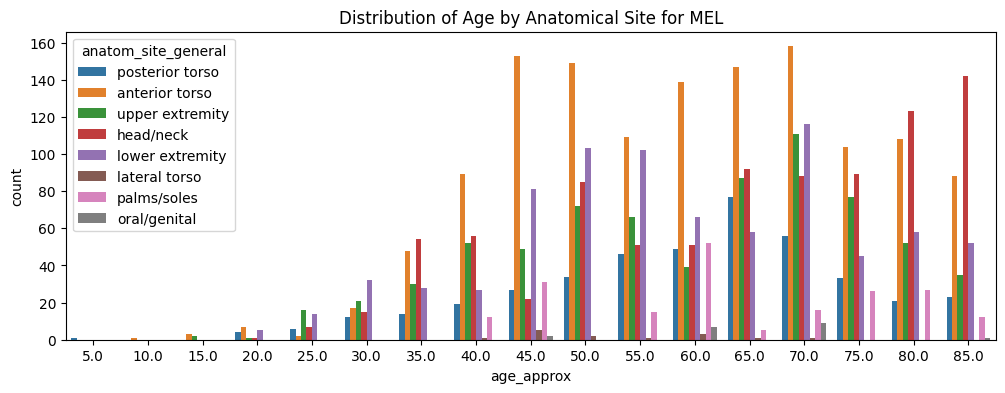

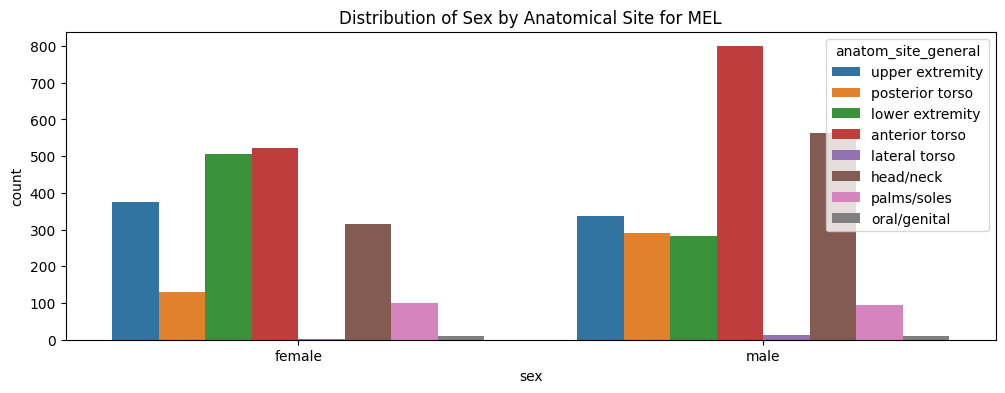

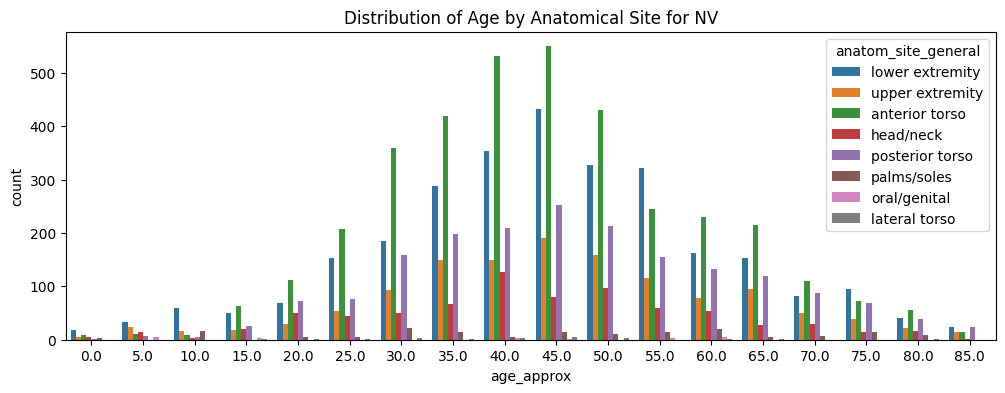

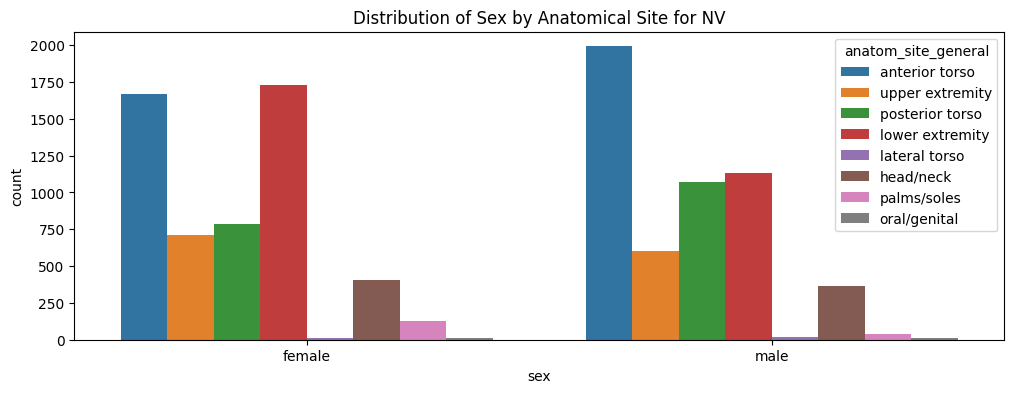

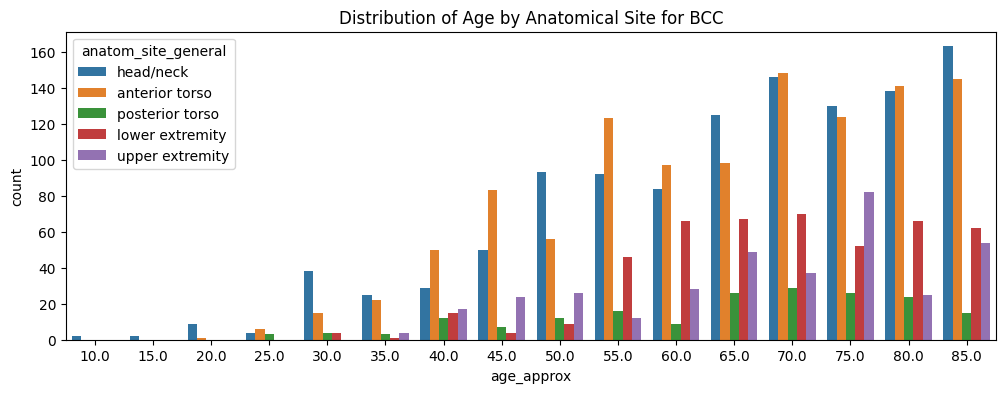

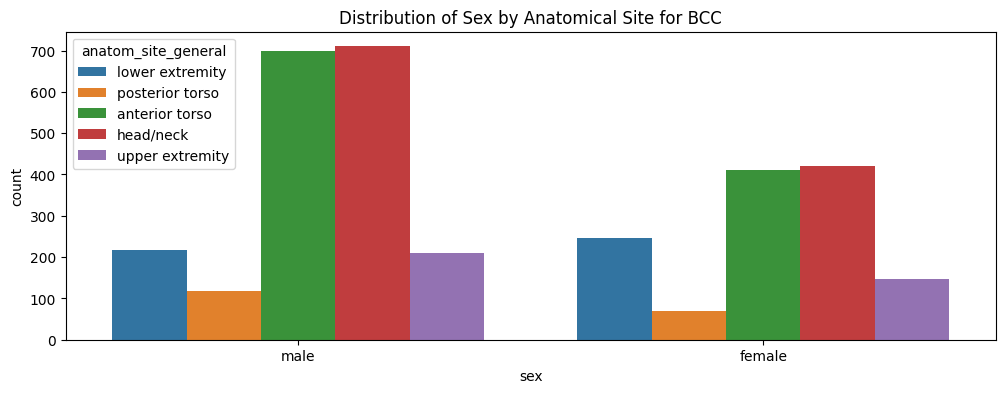

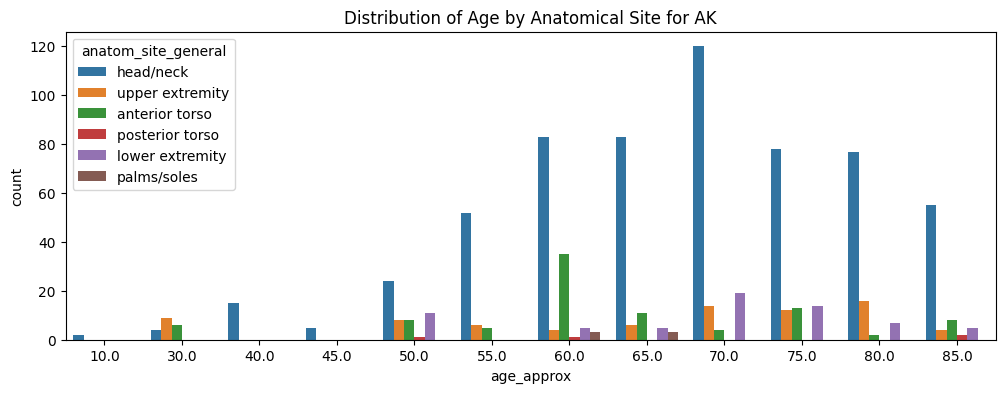

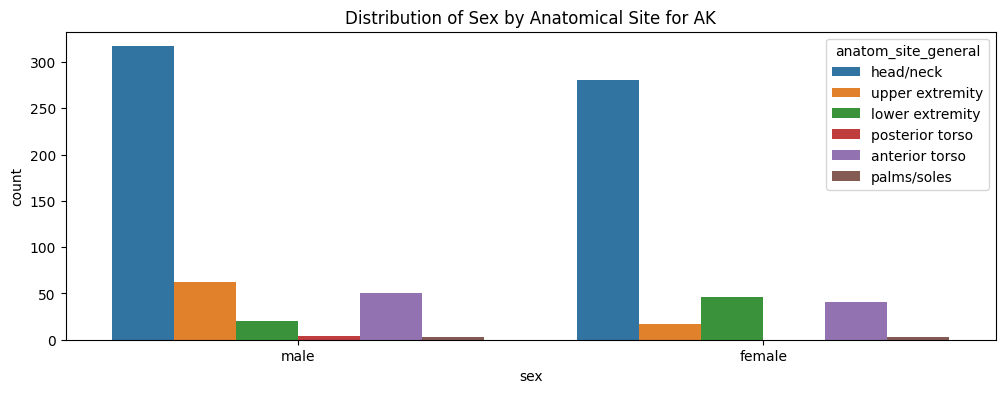

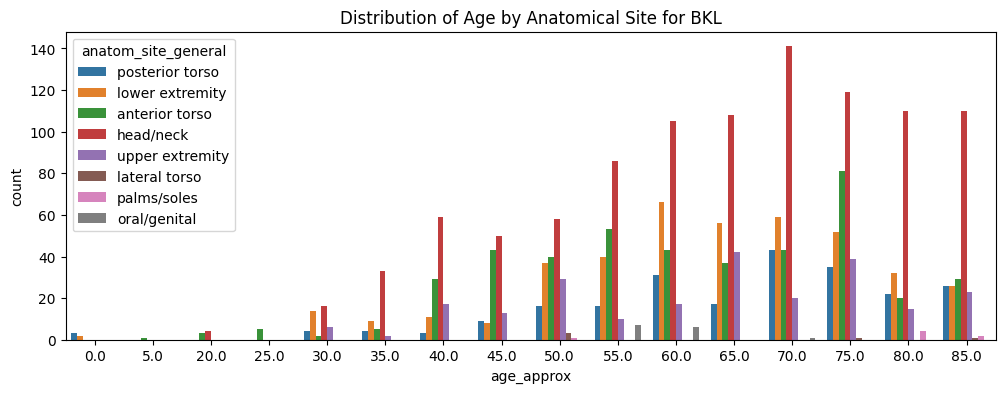

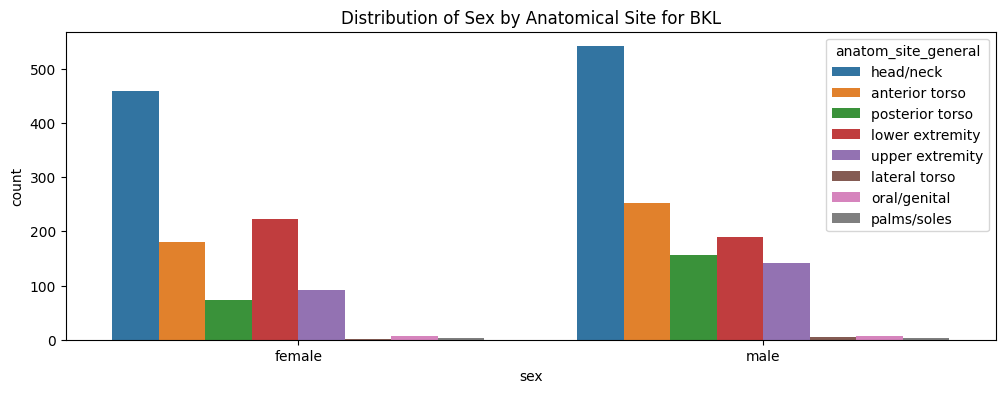

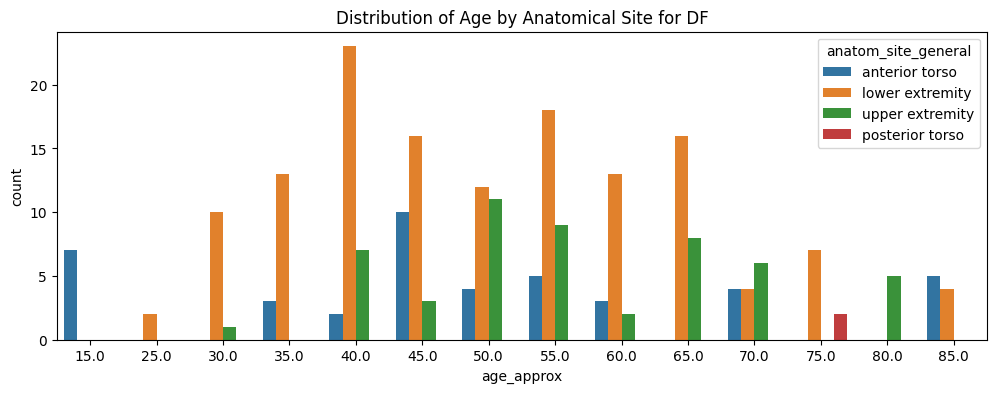

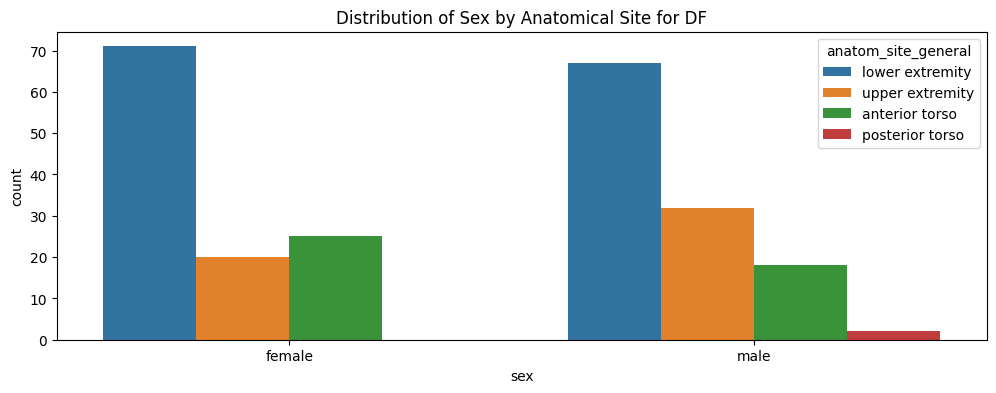

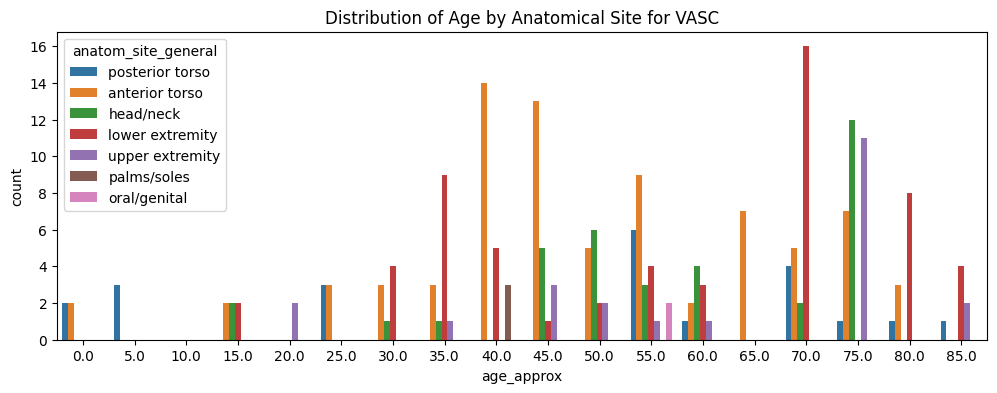

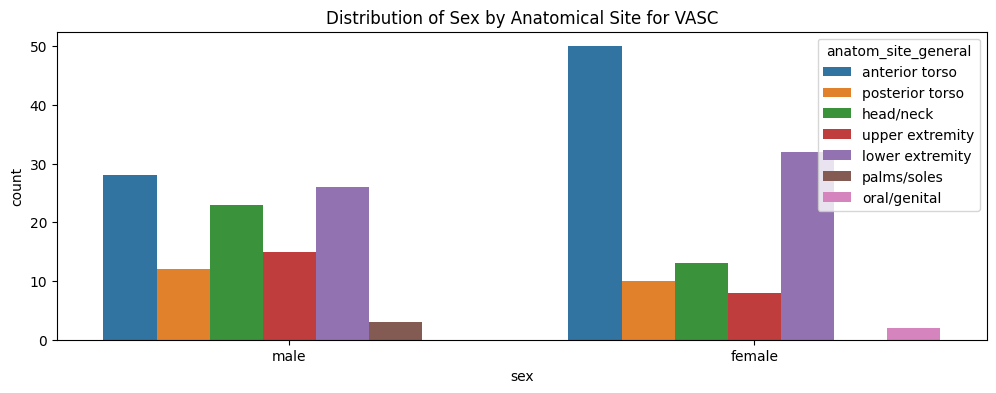

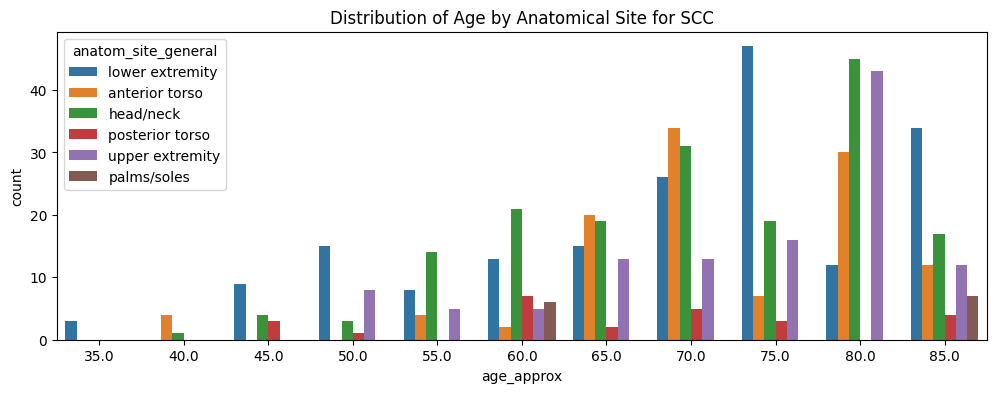

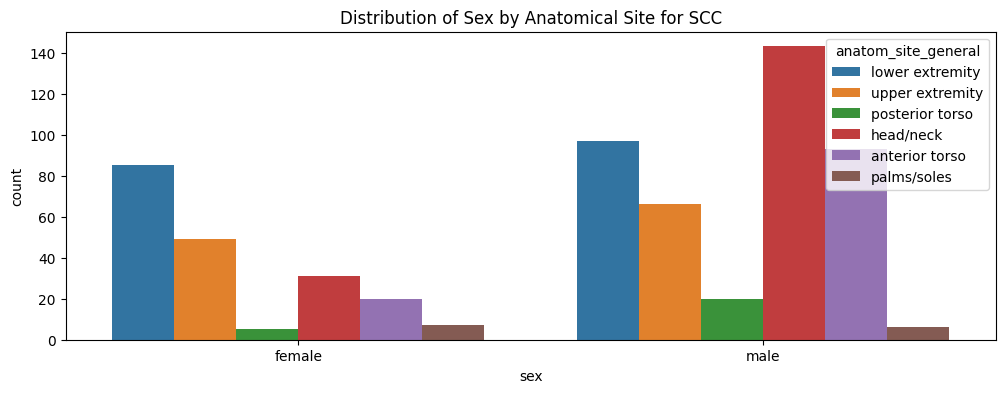

time: 10.1 s (started: 2024-07-29 07:04:39 +00:00)


In [27]:
# Loop through each disease type
for disease in disease_type:
    # Create a subset of the dataframe for the current disease type
    subset_df = combined_df[combined_df[disease] == 1]

    # Plot the distribution of 'age_approx' by 'anatom_site_general'
    plt.figure(figsize=(12, 4))
    sns.countplot(data=subset_df, x='age_approx', hue='anatom_site_general')
    plt.title(f'Distribution of Age by Anatomical Site for {disease}')
    plt.show()

    # Plot the distribution of 'sex' by 'anatom_site_general'
    plt.figure(figsize=(12, 4))
    sns.countplot(data=subset_df, x='sex', hue='anatom_site_general')
    plt.title(f'Distribution of Sex by Anatomical Site for {disease}')
    plt.show()


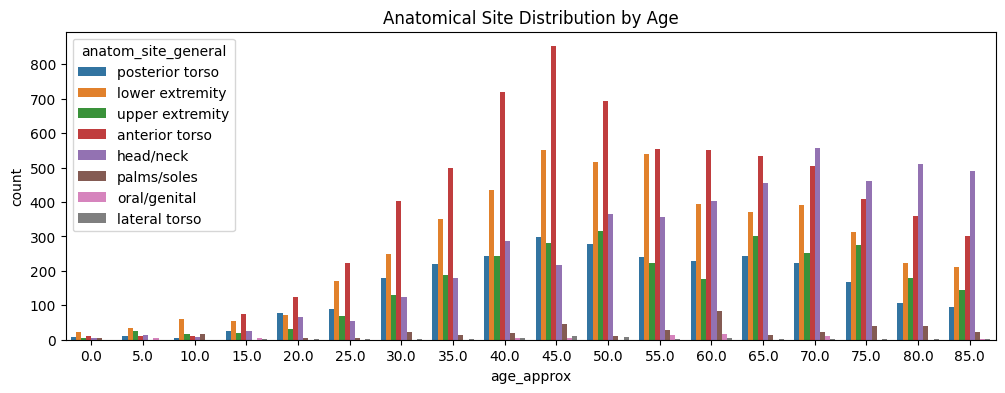

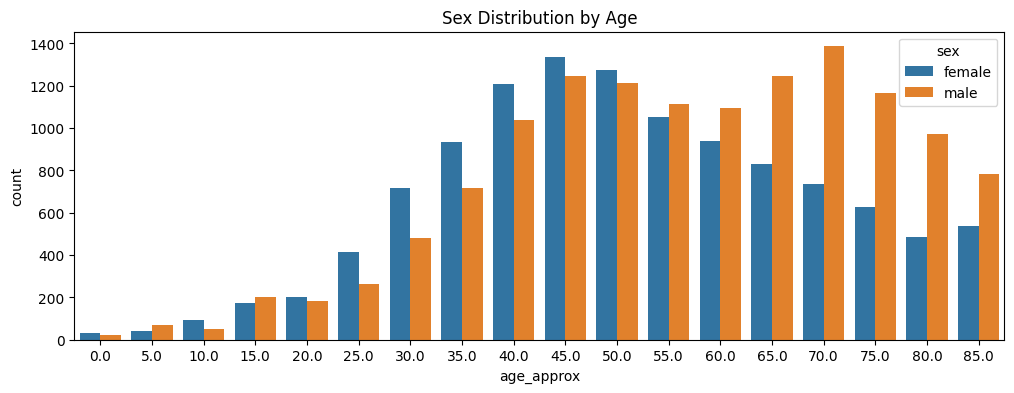

time: 3.46 s (started: 2024-07-29 07:04:49 +00:00)


In [28]:
# Visualizing relationships between categorical columns
plt.figure(figsize=(12, 4))
sns.countplot(data=train_metadata, x='age_approx', hue='anatom_site_general')
plt.title('Anatomical Site Distribution by Age')
plt.show()

# Visualizing relationships between categorical columns
plt.figure(figsize=(12, 4))
sns.countplot(data=train_metadata, x='age_approx', hue='sex')
plt.title('Sex Distribution by Age')
plt.show()

##DATA PREPROCESSING

In [29]:
train_metadata.info()
train_metadata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB


,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


time: 385 ms (started: 2024-07-29 07:04:52 +00:00)


###Data cleansing

identifying and correcting errors or inconsistencies in the data.

In [30]:
print(train_metadata.columns)

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex'], dtype='object')
time: 3.23 ms (started: 2024-07-29 07:04:53 +00:00)


In [31]:
# Convert the train_groundtruth DataFrame from wide format to long format
melted_groundtruth = train_groundtruth.melt(id_vars='image', var_name='disease_type', value_name='presence')

# Filter out rows where presence is 0 (i.e., the disease type is not present)
filtered_groundtruth = melted_groundtruth[melted_groundtruth['presence'] == 1]

# Merge the train_metadata and filtered_groundtruth DataFrames on the 'image' column
combined_train_df = pd.merge(train_metadata, filtered_groundtruth, on='image')

print(combined_train_df.columns)

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex',
       'disease_type', 'presence'],
      dtype='object')
time: 67 ms (started: 2024-07-29 07:04:53 +00:00)


In [32]:
# Removing duplicate rows
train_metadata_pp = combined_train_df.drop_duplicates()

# Removing rows with missing values
train_metadata_pp = train_metadata_pp.dropna()

# Handle Missing Entries using the median
# Replace missing values in 'age' column with median age
median_age = train_metadata_pp['age_approx'].median()
train_metadata_pp['age_approx'] = train_metadata_pp['age_approx'].fillna(median_age)


# Fixing column names
train_metadata_pp = train_metadata_pp.rename(columns={
    'image': 'Image_Id',
    'age_approx': 'Age',
    'anatom_site_general': 'Region_Of_Disease',
    'lesion_id': 'Lesion_Id',
    'sex': 'Sex',
    'disease_type': 'Disease_Type',
    'presence': 'Presence'
})


# Define the mapping of current values to new values
diagnosis_mapping = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic Nevi',
    'BCC': 'Basal Cell Carcinoma',
    'AK': 'Actinic Keratoses',
    'BKL': 'Benign Keratosis-Like Lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular Lesions',
    'SCC': 'Squamous Cell Carcinoma'
}

# Convert the Age column to integers
train_metadata_pp['Age'] = train_metadata_pp['Age'].astype(int)

# Create a new column with the updated diagnosis names
train_metadata_pp['Updated_Diagnosis'] = train_metadata_pp['Disease_Type'].map(diagnosis_mapping)



time: 151 ms (started: 2024-07-29 07:04:53 +00:00)


In [33]:
print(train_metadata_pp.columns)
print()
print(train_metadata_pp)

Index(['Image_Id', 'Age', 'Region_Of_Disease', 'Lesion_Id', 'Sex',
       'Disease_Type', 'Presence', 'Updated_Diagnosis'],
      dtype='object')

                       Image_Id  Age Region_Of_Disease     Lesion_Id     Sex  \
1459   ISIC_0012653_downsampled   50   posterior torso  MSK4_0011169  female   
1460   ISIC_0012654_downsampled   30   lower extremity  MSK4_0011170  female   
1461   ISIC_0012655_downsampled   35   upper extremity  MSK4_0011171  female   
1462   ISIC_0012656_downsampled   45   posterior torso  MSK4_0011172    male   
1463   ISIC_0012657_downsampled   20   upper extremity  MSK4_0011173  female   
...                         ...  ...               ...           ...     ...   
25326              ISIC_0073247   85         head/neck   BCN_0003925  female   
25327              ISIC_0073248   65    anterior torso   BCN_0001819    male   
25328              ISIC_0073249   70   lower extremity   BCN_0001085    male   
25329              ISIC_0073251   55       palms/sole

In [34]:
train_metadata_pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21311 entries, 1459 to 25330
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           21311 non-null  object 
 1   Age                21311 non-null  int64  
 2   Region_Of_Disease  21311 non-null  object 
 3   Lesion_Id          21311 non-null  object 
 4   Sex                21311 non-null  object 
 5   Disease_Type       21311 non-null  object 
 6   Presence           21311 non-null  float64
 7   Updated_Diagnosis  21311 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.5+ MB
time: 58.1 ms (started: 2024-07-29 07:04:53 +00:00)


In [35]:
train_metadata_pp.head()

,Image_Id,Age,Region_Of_Disease,Lesion_Id,Sex,Disease_Type,Presence,Updated_Diagnosis
1459,ISIC_0012653_downsampled,50,posterior torso,MSK4_0011169,female,NV,1.0,Melanocytic Nevi
1460,ISIC_0012654_downsampled,30,lower extremity,MSK4_0011170,female,NV,1.0,Melanocytic Nevi
1461,ISIC_0012655_downsampled,35,upper extremity,MSK4_0011171,female,NV,1.0,Melanocytic Nevi
1462,ISIC_0012656_downsampled,45,posterior torso,MSK4_0011172,male,NV,1.0,Melanocytic Nevi
1463,ISIC_0012657_downsampled,20,upper extremity,MSK4_0011173,female,NV,1.0,Melanocytic Nevi


time: 358 ms (started: 2024-07-29 07:04:53 +00:00)


###Get images data

finish preprocessing

In [36]:
train_image_dir = training_input_dir

image_paths = [os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir)]

image_path_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}

train_metadata_pp['Image_path'] = train_metadata_pp['Image_Id'].map(image_path_dict)

label_to_id = {label: idx for idx, label in enumerate(train_metadata_pp['Disease_Type'].unique())}

time: 1min 47s (started: 2024-07-29 07:04:54 +00:00)


In [37]:
train_metadata_pp

,Image_Id,Age,Region_Of_Disease,Lesion_Id,Sex,Disease_Type,Presence,Updated_Diagnosis,Image_path
1459,ISIC_0012653_downsampled,50,posterior torso,MSK4_0011169,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
1460,ISIC_0012654_downsampled,30,lower extremity,MSK4_0011170,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
1461,ISIC_0012655_downsampled,35,upper extremity,MSK4_0011171,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
1462,ISIC_0012656_downsampled,45,posterior torso,MSK4_0011172,male,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
1463,ISIC_0012657_downsampled,20,upper extremity,MSK4_0011173,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85,head/neck,BCN_0003925,female,BCC,1.0,Basal Cell Carcinoma,/content/drive/MyDrive/MASTER 1/Internship/ICT...
25327,ISIC_0073248,65,anterior torso,BCN_0001819,male,BKL,1.0,Benign Keratosis-Like Lesions,/content/drive/MyDrive/MASTER 1/Internship/ICT...
25328,ISIC_0073249,70,lower extremity,BCN_0001085,male,MEL,1.0,Melanoma,/content/drive/MyDrive/MASTER 1/Internship/ICT...
25329,ISIC_0073251,55,palms/soles,BCN_0002083,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...


time: 168 ms (started: 2024-07-29 07:06:41 +00:00)


In [38]:
train_metadata_pp = train_metadata_pp.sample(n=100, random_state=42)
train_metadata_pp

,Image_Id,Age,Region_Of_Disease,Lesion_Id,Sex,Disease_Type,Presence,Updated_Diagnosis,Image_path
19360,ISIC_0063801,45,anterior torso,BCN_0004924,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
14604,ISIC_0056188,30,anterior torso,BCN_0003168,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
13740,ISIC_0054796,80,anterior torso,BCN_0003196,female,MEL,1.0,Melanoma,/content/drive/MyDrive/MASTER 1/Internship/ICT...
10139,ISIC_0031542,45,upper extremity,HAM_0003014,male,BKL,1.0,Benign Keratosis-Like Lesions,/content/drive/MyDrive/MASTER 1/Internship/ICT...
17909,ISIC_0061473,75,head/neck,BCN_0000195,female,BCC,1.0,Basal Cell Carcinoma,/content/drive/MyDrive/MASTER 1/Internship/ICT...
...,...,...,...,...,...,...,...,...,...
16496,ISIC_0059214,30,anterior torso,BCN_0000260,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
19126,ISIC_0063412,35,upper extremity,BCN_0001633,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
3252,ISIC_0024655,30,posterior torso,HAM_0000013,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
8586,ISIC_0029989,40,anterior torso,HAM_0000834,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...


time: 75.8 ms (started: 2024-07-29 07:06:42 +00:00)


In [40]:
train_metadata_pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 19360 to 10014
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           100 non-null    object 
 1   Age                100 non-null    int64  
 2   Region_Of_Disease  100 non-null    object 
 3   Lesion_Id          100 non-null    object 
 4   Sex                100 non-null    object 
 5   Disease_Type       100 non-null    object 
 6   Presence           100 non-null    float64
 7   Updated_Diagnosis  100 non-null    object 
 8   Image_path         100 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 7.8+ KB
time: 46.2 ms (started: 2024-07-29 07:07:20 +00:00)


#MODEL IMPLEMENTATION

##Functionalities

###Correctting image paths

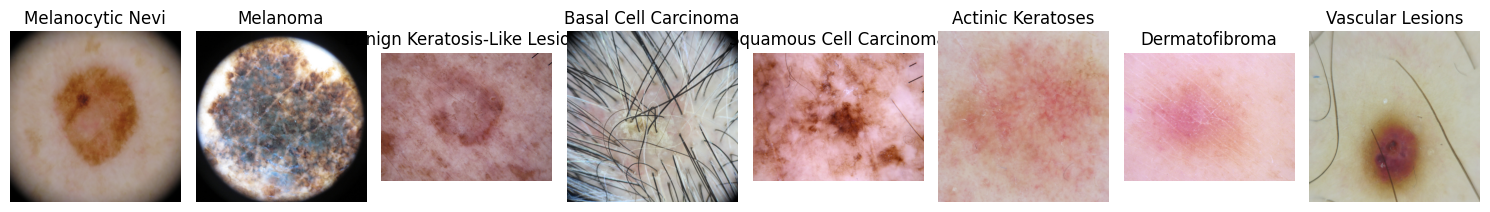

time: 14.9 s (started: 2024-07-29 07:06:50 +00:00)


In [39]:
# Ensure that the image paths are correct and accessible
for i in range(len(train_metadata_pp)):
    if not os.path.isfile(train_metadata_pp['Image_path'].iloc[i]):
        raise FileNotFoundError(f"Image file not found: {train_metadata_pp['Image_path'].iloc[i]}")

# Get one image per class
class_images = train_metadata_pp.drop_duplicates(subset='Updated_Diagnosis')

# Plot one image per class
def plot_class_images(class_images):
    plt.figure(figsize=(15, 5))
    num_classes = len(class_images)
    for i in range(num_classes):
        plt.subplot(1, num_classes, i + 1)
        img = plt.imread(class_images['Image_path'].iloc[i])
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_images['Updated_Diagnosis'].iloc[i], fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the function to plot images
plot_class_images(class_images)

###Label Encoder

In [41]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder and transform 'Region_Of_Disease' column
train_metadata_pp['Updated_Diagnosis_Label'] = label_encoder.fit_transform(train_metadata_pp['Updated_Diagnosis'])

# Display the mapping between original labels and encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
print(label_mapping)

Label Encoding Mapping:
{'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis-Like Lesions': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Squamous Cell Carcinoma': 6, 'Vascular Lesions': 7}
time: 4.89 ms (started: 2024-07-29 07:07:36 +00:00)


In [42]:
train_metadata_pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 19360 to 10014
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Image_Id                 100 non-null    object 
 1   Age                      100 non-null    int64  
 2   Region_Of_Disease        100 non-null    object 
 3   Lesion_Id                100 non-null    object 
 4   Sex                      100 non-null    object 
 5   Disease_Type             100 non-null    object 
 6   Presence                 100 non-null    float64
 7   Updated_Diagnosis        100 non-null    object 
 8   Image_path               100 non-null    object 
 9   Updated_Diagnosis_Label  100 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 8.6+ KB
time: 12.5 ms (started: 2024-07-29 07:07:43 +00:00)


In [43]:
train_metadata_pp

,Image_Id,Age,Region_Of_Disease,Lesion_Id,Sex,Disease_Type,Presence,Updated_Diagnosis,Image_path,Updated_Diagnosis_Label
19360,ISIC_0063801,45,anterior torso,BCN_0004924,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...,4
14604,ISIC_0056188,30,anterior torso,BCN_0003168,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...,4
13740,ISIC_0054796,80,anterior torso,BCN_0003196,female,MEL,1.0,Melanoma,/content/drive/MyDrive/MASTER 1/Internship/ICT...,5
10139,ISIC_0031542,45,upper extremity,HAM_0003014,male,BKL,1.0,Benign Keratosis-Like Lesions,/content/drive/MyDrive/MASTER 1/Internship/ICT...,2
17909,ISIC_0061473,75,head/neck,BCN_0000195,female,BCC,1.0,Basal Cell Carcinoma,/content/drive/MyDrive/MASTER 1/Internship/ICT...,1
...,...,...,...,...,...,...,...,...,...,...
16496,ISIC_0059214,30,anterior torso,BCN_0000260,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...,4
19126,ISIC_0063412,35,upper extremity,BCN_0001633,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...,4
3252,ISIC_0024655,30,posterior torso,HAM_0000013,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...,4
8586,ISIC_0029989,40,anterior torso,HAM_0000834,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...,4


time: 36.8 ms (started: 2024-07-29 07:07:51 +00:00)


##Augment and Balance classes

In [44]:
# Define your augmentation pipeline
aug_pipeline = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip with probability 0.5
    iaa.Affine(rotate=(-10, 10)),  # Random rotation within -10 to 10 degrees
    iaa.Affine(scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}),  # Random scaling within 90% to 110%
    iaa.Affine(shear=(-5, 5)),  # Random shear within -5 to 5 degrees
    iaa.GaussianBlur(sigma=(0, 0.5)),  # Gaussian blur with a small sigma
    iaa.AdditiveGaussianNoise(scale=(0, 0.01*255)),  # Small additive Gaussian noise
    iaa.ContrastNormalization((0.9, 1.1)),  # Slightly change contrast
    iaa.CLAHE(clip_limit=(1, 2))  # Apply CLAHE with a moderate clip limit
])

# Directory to save augmented images
# augmented_images_dir = '/path/to/augmented_images'
augmented_images_dir = '/content/augmented_images'
os.makedirs(augmented_images_dir, exist_ok=True)

# Get the class counts
class_counts = train_metadata_pp['Disease_Type'].value_counts()
max_count = class_counts.max()

# Create an empty list to hold the balanced samples
balanced_samples = []

# Oversample each class with augmentation to match the class with the maximum count
for label in class_counts.index:
    class_subset = train_metadata_pp[train_metadata_pp['Disease_Type'] == label]
    n_samples = min(len(class_subset), 100)
    class_subset = class_subset.sample(n=n_samples, replace=len(class_subset)<100, random_state=42)

    if len(class_subset) < max_count:
        n_augmentations = max_count - len(class_subset)
        augmented_samples = []
        for i in range(n_augmentations):
            sample = class_subset.sample(n=1, random_state=42).iloc[0]
            img_path = sample['Image_path']
            img = io.imread(img_path)
            augmented_image = aug_pipeline(image=img)

            # Save the augmented image
            augmented_image_path = os.path.join(augmented_images_dir, f'{label}_augmented_{i}.jpg')
            io.imsave(augmented_image_path, augmented_image)

            # Store the augmented image and update the image path
            augmented_sample = sample.copy()
            augmented_sample['Image_path'] = augmented_image_path
            augmented_samples.append(augmented_sample)

        augmented_df = pd.DataFrame(augmented_samples)
        class_oversampled = pd.concat([class_subset, augmented_df], ignore_index=True)
    else:
        class_oversampled = class_subset

    balanced_samples.append(class_oversampled)

# Combine all oversampled classes into a single DataFrame
balanced_dataset = pd.concat(balanced_samples).reset_index(drop=True)

print("Dataset balanced successfully!")

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Dataset balanced successfully!
time: 32.9 s (started: 2024-07-29 07:07:58 +00:00)


In [45]:
# Rename the DataFrame to meta_data
meta_data = balanced_dataset
meta_data

,Image_Id,Age,Region_Of_Disease,Lesion_Id,Sex,Disease_Type,Presence,Updated_Diagnosis,Image_path,Updated_Diagnosis_Label
0,ISIC_0064251,60,anterior torso,BCN_0002732,male,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...,4
1,ISIC_0029556,60,posterior torso,HAM_0001831,male,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...,4
2,ISIC_0068890,25,lower extremity,BCN_0001774,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...,4
3,ISIC_0024655,30,posterior torso,HAM_0000013,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...,4
4,ISIC_0030483,35,lower extremity,HAM_0006569,male,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...,4
...,...,...,...,...,...,...,...,...,...,...
347,ISIC_0058394,40,lower extremity,BCN_0004935,male,VASC,1.0,Vascular Lesions,/content/augmented_images/VASC_augmented_38.jpg,7
348,ISIC_0058394,40,lower extremity,BCN_0004935,male,VASC,1.0,Vascular Lesions,/content/augmented_images/VASC_augmented_39.jpg,7
349,ISIC_0058394,40,lower extremity,BCN_0004935,male,VASC,1.0,Vascular Lesions,/content/augmented_images/VASC_augmented_40.jpg,7
350,ISIC_0058394,40,lower extremity,BCN_0004935,male,VASC,1.0,Vascular Lesions,/content/augmented_images/VASC_augmented_41.jpg,7


time: 75.8 ms (started: 2024-07-29 07:22:18 +00:00)


In [46]:
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Image_Id                 352 non-null    object 
 1   Age                      352 non-null    int64  
 2   Region_Of_Disease        352 non-null    object 
 3   Lesion_Id                352 non-null    object 
 4   Sex                      352 non-null    object 
 5   Disease_Type             352 non-null    object 
 6   Presence                 352 non-null    float64
 7   Updated_Diagnosis        352 non-null    object 
 8   Image_path               352 non-null    object 
 9   Updated_Diagnosis_Label  352 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 27.6+ KB
time: 9.59 ms (started: 2024-07-29 07:22:21 +00:00)


##Split data

In [47]:
# Randomly sample 1000 rows from the DataFrame
# meta_data = meta_data.sample(n=1000, random_state=42)

# Separate features (X) and target variable (y)
X = meta_data.drop(columns=['Updated_Diagnosis_Label'])
y = meta_data['Updated_Diagnosis_Label']

# Display the shape of X and y
print("Shape of features (X):", X.shape)
print("Shape of target variable (y):", y.shape)

# Perform initial train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Shape of features (X): (352, 9)
Shape of target variable (y): (352,)
time: 12.1 ms (started: 2024-07-29 07:22:35 +00:00)


In [48]:
# Data augmentation and generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.8, 1.2],
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    x_col='Image_path',
    y_col='Updated_Diagnosis',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=X_val,
    x_col='Image_path',
    y_col='Updated_Diagnosis',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=X_test,
    x_col='Image_path',
    y_col='Updated_Diagnosis',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 281 validated image filenames belonging to 8 classes.
Found 35 validated image filenames belonging to 8 classes.
Found 36 validated image filenames belonging to 8 classes.
time: 78.3 ms (started: 2024-07-29 07:22:39 +00:00)


##Models Initialization

###Load pre-trained models

In [49]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50v2 = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
xception = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

83683744/83683744 [==============================] - 1s 0us/step
time: 15.1 s (started: 2024-07-29 07:22:49 +00:00)


###Define an ensemble model

In [53]:
# Create a function to build a model from a base model
def create_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

time: 713 µs (started: 2024-07-29 07:23:04 +00:00)


In [52]:
def create_custom_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model


time: 1.1 ms (started: 2024-07-29 07:23:04 +00:00)


In [50]:
def create_model_for_pretrained(base_model, num_classes):
    x = base_model.output
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

time: 1.7 ms (started: 2024-07-29 07:23:04 +00:00)


In [51]:
def create_ensemble_concat(models, model_input):
    # Collect outputs of models in a list
    outputs = [model.outputs[0] for model in models]

    # Concatenate the outputs
    y = concatenate(outputs)

    # Define a dense layer followed by a softmax
    y = Dense(512, activation='relu')(y)
    y = Dense(num_classes, activation='softmax')(y)

    # Define the ensemble model
    model = Model(model_input, y, name='ensemble')

    return model

time: 994 µs (started: 2024-07-29 07:23:04 +00:00)


In [ ]:
# def create_ensemble_voting(models, model_names, num_classes, X_train, y_train, X_test, y_test):
#     # Wrap Keras models for use in scikit-learn
#     keras_models = [KerasClassifier(build_fn=create_model(model, num_classes), epochs=10, verbose=0) for model in models]

#     # Create voting ensemble
#     ensemble = VotingClassifier(estimators=list(zip(model_names, keras_models)), voting='soft')

#     # Fit ensemble on training data
#     ensemble.fit(X_train, y_train)

#     # Evaluate ensemble on test data
#     accuracy = ensemble.score(X_test, y_test)
#     print('Test accuracy:', accuracy)

#     return ensemble

time: 362 µs (started: 2024-07-28 11:25:40 +00:00)


In [54]:
def create_ensemble_voting(models, model_names, num_classes, X_train, y_train, X_test, y_test):
    # Wrap Keras models for use in scikit-learn
    keras_models = []
    for model in models:
        keras_model = KerasClassifier(build_fn=create_model(model, num_classes), epochs=10, verbose=0)
        keras_model.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        keras_model.fit(X_train, y_train)
        keras_models.append(keras_model)

    # Create voting ensemble
    ensemble = VotingClassifier(estimators=list(zip(model_names, keras_models)), voting='soft')

    # Fit ensemble on training data
    ensemble.fit(X_train, y_train)

    # Evaluate ensemble on test data
    accuracy = ensemble.score(X_test, y_test)
    print('Test accuracy:', accuracy)

    return ensemble

time: 1.1 ms (started: 2024-07-29 07:23:11 +00:00)


In [55]:
# Create a model for each base model
num_classes = meta_data['Updated_Diagnosis'].nunique()
print("Number of unique classes:", num_classes)

model_vgg19 = create_model(vgg19, num_classes)
model_resnet50v2 = create_model(resnet50v2, num_classes)
model_inceptionv3 = create_model(inceptionv3, num_classes)
model_xception = create_model(xception, num_classes)

# Create the custom CNN model
model_CNN = create_custom_model((224, 224, 3), num_classes)

Number of unique classes: 8
time: 705 ms (started: 2024-07-29 07:23:14 +00:00)


In [56]:
num_classes_val = X_val['Updated_Diagnosis'].nunique()
print("Number of unique classes in validation data:", num_classes_val)


Number of unique classes in validation data: 8
time: 1.63 ms (started: 2024-07-29 07:23:17 +00:00)


In [ ]:
# Compile and train each model
print("VGG19")
model_vgg19.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg19.fit(train_generator, validation_data=val_generator, epochs=10)

print("ResNet50V2")
model_resnet50v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet50v2.fit(train_generator, validation_data=val_generator, epochs=10)

print("InceptionV3")
model_inceptionv3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_inceptionv3.fit(train_generator, validation_data=val_generator, epochs=10)

print("Xception")
model_xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_xception.fit(train_generator, validation_data=val_generator, epochs=10)


# Compile the custom CNN model
model_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_CNN.fit(train_generator, validation_data=val_generator, epochs=10)

VGG19
Epoch 1/10
9/9 [==============================] - 726s 82s/step - loss: 5.4177 - accuracy: 0.1139 - val_loss: 2.1199 - val_accuracy: 0.0571
Epoch 2/10
9/9 [==============================] - 719s 80s/step - loss: 2.1238 - accuracy: 0.0996 - val_loss: 2.1849 - val_accuracy: 0.0571
Epoch 3/10
9/9 [==============================] - 690s 77s/step - loss: 2.1318 - accuracy: 0.0925 - val_loss: 2.0996 - val_accuracy: 0.1714
Epoch 4/10
9/9 [==============================] - 688s 76s/step - loss: 2.0985 - accuracy: 0.1317 - val_loss: 2.0943 - val_accuracy: 0.1714
Epoch 5/10
9/9 [==============================] - 687s 76s/step - loss: 2.0892 - accuracy: 0.1246 - val_loss: 2.0961 - val_accuracy: 0.1714
Epoch 6/10
9/9 [==============================] - 685s 76s/step - loss: 2.0858 - accuracy: 0.1210 - val_loss: 2.0977 - val_accuracy: 0.0571
Epoch 7/10
9/9 [==============================] - 685s 76s/step - loss: 2.0807 - accuracy: 0.1068 - val_loss: 2.0981 - val_accuracy: 0.0571
Epoch 8/10
9/9

In [ ]:
# # Train the models
# epochs = 10  # replace with the number of epochs you want to train for
# for model in [model_vgg19, model_resnet50v2, model_inceptionv3, model_xception]:
#     model.fit(train_generator, epochs=epochs, validation_data=val_generator)


In [ ]:
# Make predictions with each model
preds_vgg19 = model_vgg19.predict(test_generator)
preds_resnet50v2 = model_resnet50v2.predict(test_generator)
preds_inceptionv3 = model_inceptionv3.predict(test_generator)
preds_xception = model_xception.predict(test_generator)

In [ ]:
# List of all models
models = [model_vgg19, model_resnet50v2, model_inceptionv3, model_xception]
model_names = ['vgg19', 'resnet50v2', 'inceptionv3', 'xception']

# Create ensemble model
ensemble_model_concat = create_ensemble(models, model_input)

# Compile the ensemble model
ensemble_model_concat.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:

# Create and evaluate ensemble model
ensemble_model_voting = create_ensemble(models, model_names, num_classes, X_train, y_train, X_test, y_test)

##Model works

#DEFINE FUNCTIONS

## Preprocessing


##Visualization

##Input image

#TESING MODELS

##Feature extraction

##Get test images

##Test the model